In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from discopy import grammar
from discopy import Dim

from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter

2022-08-23 17:03:06.536662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 17:03:06.624886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 17:03:06.624901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-23 17:03:08.080943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 17:03:08.080961: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 17:03:08.080972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maria-pc): /proc/driver/nvidia/version does not exist


In [3]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

In [4]:
#Input data MC1

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [5]:
#we will use 15% of the data as a training set
labels, data = read_data('MC1.TXT')
train_labels, train_data = labels[0:15] , data[0:15]
test_labels, test_data = labels[15:100] , data[15:100]

In [6]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [7]:
train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
test_diagrams = [
    diagram.normal_form()
    for diagram in test_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(test_diagrams, test_labels)
    if diagram is not None]

In [8]:
#Circuits
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

In [9]:
#render circuits
render_circuit_jupyter(train_circuits[14].to_tk())

In [10]:
#Model
all_circuits = train_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}


#Training from diagrams
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)


In [11]:
#Loss & eval metrics
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [12]:
#Trainer
 
#Standart model
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [13]:
#Create dataset
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [14]:
#Train model
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:    train/loss: 4.1082   valid/loss: 3.8586   train/acc: 0.3000   valid/acc: 0.5176


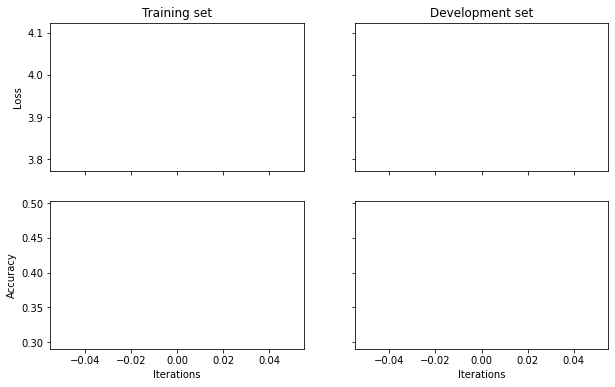

In [ ]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))